
# LoRaSim: simulate collisions in LoRa
Copyright © 2016 Thiemo Voigt <thiemo@sics.se> and Martin Bor <m.bor@lancaster.ac.uk>

This work is licensed under the Creative Commons Attribution 4.0
International License. To view a copy of this license,
visit http://creativecommons.org/licenses/by/4.0/.

Do LoRa Low-Power Wide-Area Networks Scale? Martin Bor, Utz Roedig, Thiemo Voigt
and Juan Alonso, MSWiM '16, http://dx.doi.org/10.1145/2988287.2989163

*Date: 2016-10-17 13:23:52 +0100 (Mon, 17 Oct 2016) *
*Revision: 218 *

## SYNOPSIS:
```
./loraDir.py <nodes> <avgsend> <experiment> <simtime> [collision]
```
## DESCRIPTION:
`nodes`: number of nodes to simulate

`avgsend`: average sending interval in milliseconds. Exponentially distributed

`experiment`: experiment is an integer that determines with what radio settings the
simulation is run. All nodes are configured with a fixed transmit power
and a single transmit frequency, unless stated otherwise.
- `0`- use the settings with the the slowest datarate (SF12, BW125, CR4/8).
- `1`- similair to experiment 0, but use a random choice of 3 transmit
    frequencies.
- `2`- use the settings with the fastest data rate (SF6, BW500, CR4/5).
- `3`- optimise the setting per node based on the distance to the gateway.
- `4`- use the settings as defined in LoRaWAN (SF12, BW125, CR4/5).
- `5`- similair to experiment 3, but also optimises the transmit power.

`simtime`: total running time in milliseconds

`collision`: set to 1 to enable the full collision check, 0 to use a simplified check. With the simplified check, two messages collide when they arrive at the same time, on the same frequency and spreading factor. The full collision check considers the 'capture effect', whereby a collision of one or the
## OUTPUT
The result of every simulation run will be appended to a file named expX.dat,
whereby X is the experiment number. The file contains a space separated table
of values for nodes, collisions, transmissions and total energy spent. The
data file can be easily plotted using e.g. gnuplot.

In [8]:
import simpy
import random
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
import os

In [31]:
# turn on/off graphics
graphics = True

# do the full collision check
full_collision = False

# experiments:
# 0: packet with longest airtime, aloha-style experiment
# 0: one with 3 frequencies, 1 with 1 frequency
# 2: with shortest packets, still aloha-style
# 3: with shortest possible packets depending on distance



# this is an array with measured values for sensitivity
# see paper, Table 3
sf7 = np.array([7,-126.5,-124.25,-120.75])
sf8 = np.array([8,-127.25,-126.75,-124.0])
sf9 = np.array([9,-131.25,-128.25,-127.5])
sf10 = np.array([10,-132.75,-130.25,-128.75])
sf11 = np.array([11,-134.5,-132.75,-128.75])
sf12 = np.array([12,-133.25,-132.25,-132.25])

#
# check for collisions at base station
# Note: called before a packet (or rather node) is inserted into the list
#
# conditions for collions:
#     1. same sf
#     2. frequency, see function below (Martins email, not implementet yet):
def checkcollision(packet):
    col = 0 # flag needed since there might be several collisions for packet
    processing = 0
    global packetsAtBS
    for i in range(0,len(packetsAtBS)):
        if packetsAtBS[i].packet.processed == 1:
            processing = processing + 1
    if (processing > maxBSReceives):
        print "too long: {}".format(len(packetsAtBS))
        packet.processed = 0
    else:
        packet.processed = 1

    if packetsAtBS:
        print "CHECK node {} (sf:{} bw:{} freq:{:.6e}) others: {}".format(
             packet.nodeid, packet.sf, packet.bw, packet.freq,
             len(packetsAtBS))
        for other in packetsAtBS:
            if other.nodeid != packet.nodeid:
               print ">> node {} (sf:{} bw:{} freq:{:.6e})".format(
                   other.nodeid, other.packet.sf, other.packet.bw, other.packet.freq)
               # simple collision
               if frequencyCollision(packet, other.packet) \
                   and sfCollision(packet, other.packet):
                   if full_collision:
                       if timingCollision(packet, other.packet):
                           # check who collides in the power domain
                           c = powerCollision(packet, other.packet)
                           # mark all the collided packets
                           # either this one, the other one, or both
                           for p in c:
                               p.collided = 1
                       else:
                           # no timing collision, all fine
                           pass
                   else:
                       packet.collided = 1
                       other.packet.collided = 1  # other also got lost, if it wasn't lost already
                       col = 1
        return col
    return 0

#
# frequencyCollision, conditions
#
#        |f1-f2| <= 120 kHz if f1 or f2 has bw 500
#        |f1-f2| <= 60 kHz if f1 or f2 has bw 250
#        |f1-f2| <= 30 kHz if f1 or f2 has bw 125
def frequencyCollision(p1,p2):
    if (abs(p1.freq-p2.freq)<=120 and (p1.bw==500 or p2.freq==500)):
        print "frequency coll 500"
        return True
    elif (abs(p1.freq-p2.freq)<=60 and (p1.bw==250 or p2.freq==250)):
        print "frequency coll 250"
        return True
    else:
        if (abs(p1.freq-p2.freq)<=30):
            print "frequency coll 125"
            return True
        #else:
    print "no frequency coll"
    return False

#
# sfCollision, conditions
#
#       sf1 == sf2
#
def sfCollision(p1, p2):
    if p1.sf == p2.sf:
        print "collision sf node {} and node {}".format(p1.nodeid, p2.nodeid)
        # p2 may have been lost too, will be marked by other checks
        return True
    print "no sf collision"
    return False

def powerCollision(p1, p2):
    powerThreshold = 6 # dB
    print "pwr: node {0.nodeid} {0.rssi:3.2f} dBm node {1.nodeid} {1.rssi:3.2f} dBm; diff {2:3.2f} dBm".format(p1, p2, round(p1.rssi - p2.rssi,2))
    if abs(p1.rssi - p2.rssi) < powerThreshold:
        print "collision pwr both node {} and node {}".format(p1.nodeid, p2.nodeid)
        # packets are too close to each other, both collide
        # return both packets as casualties
        return (p1, p2)
    elif p1.rssi - p2.rssi < powerThreshold:
        # p2 overpowered p1, return p1 as casualty
        print "collision pwr node {} overpowered node {}".format(p2.nodeid, p1.nodeid)
        return (p1,)
    print "p1 wins, p2 lost"
    # p2 was the weaker packet, return it as a casualty
    return (p2,)

def timingCollision(p1, p2):
    # assuming p1 is the freshly arrived packet and this is the last check
    # we've already determined that p1 is a weak packet, so the only
    # way we can win is by being late enough (only the first n - 5 preamble symbols overlap)

    # assuming 8 preamble symbols
    Npream = 8

    # we can lose at most (Npream - 5) * Tsym of our preamble
    Tpreamb = 2**p1.sf/(1.0*p1.bw) * (Npream - 5)

    # check whether p2 ends in p1's critical section
    p2_end = p2.addTime + p2.rectime
    p1_cs = env.now + Tpreamb
    print "collision timing node {} ({},{},{}) node {} ({},{})".format(
        p1.nodeid, env.now - env.now, p1_cs - env.now, p1.rectime,
        p2.nodeid, p2.addTime - env.now, p2_end - env.now
    )
    if p1_cs < p2_end:
        # p1 collided with p2 and lost
        print "not late enough"
        return True
    print "saved by the preamble"
    return False

# this function computes the airtime of a packet
# according to LoraDesignGuide_STD.pdf
#
def airtime(sf,cr,pl,bw):
    H = 0        # implicit header disabled (H=0) or not (H=1)
    DE = 0       # low data rate optimization enabled (=1) or not (=0)
    Npream = 8   # number of preamble symbol (12.25  from Utz paper)

    if bw == 125 and sf in [11, 12]:
        # low data rate optimization mandated for BW125 with SF11 and SF12
        DE = 1
    if sf == 6:
        # can only have implicit header with SF6
        H = 1

    Tsym = (2.0**sf)/bw
    Tpream = (Npream + 4.25)*Tsym
#     print "sf {}, cr {}, pl {}, bw {}".format(sf, cr, pl, bw)
    payloadSymbNB = 8 + max(math.ceil((8.0*pl-4.0*sf+28+16-20*H)/(4.0*(sf-2*DE)))*(cr+4),0)
    Tpayload = payloadSymbNB * Tsym
    return Tpream + Tpayload

#
# this function creates a node
#
class myNode():
    def __init__(self, nodeid, x, y, bs, period, packetlen):
        self.nodeid = nodeid
        self.period = period
        self.bs = bs
        self.x = x
        self.y = y

        self.dist = np.sqrt((self.x-bsx)*(self.x-bsx)+(self.y-bsy)*(self.y-bsy))
        print('node %d' %nodeid, "x", self.x, "y", self.y, "dist: ", self.dist)

        self.packet = myPacket(self.nodeid, packetlen, self.dist)
        self.sent = 0

#
# this function creates a packet (associated with a node)
# it also sets all parameters, currently random
#
class myPacket():
    
    # TODO: add position, SF, CR BW assignment to initializer - Adwait
    def __init__(self, nodeid, plen, distance):
        global experiment
        global Ptx
        global gamma
        global d0
        global var
        global Lpld0
        global GL

        self.nodeid = nodeid
        self.txpow = Ptx

        # randomize configuration values
        self.sf = random.randint(6,12)
        self.cr = random.randint(1,4)
        self.bw = random.choice([125, 250, 500])

        # for certain experiments override these
        if experiment==1 or experiment == 0:
            self.sf = 12
            self.cr = 4
            self.bw = 125

        # for certain experiments override these
        if experiment==2:
            self.sf = 6
            self.cr = 1
            self.bw = 500
        # lorawan
        if experiment == 4:
            self.sf = 12
            self.cr = 1
            self.bw = 125


        # for experiment 3 find the best setting
        # OBS, some hardcoded values
        Prx = self.txpow  ## zero path loss by default

        # log-shadow
        Lpl = Lpld0 + 10*gamma*math.log(distance/d0)
        print "Lpl:", Lpl
        Prx = self.txpow - GL - Lpl

        if (experiment == 3) or (experiment == 5):
            minairtime = 9999
            minsf = 0
            minbw = 0

            print "Prx:", Prx

            for i in range(0,6):
                for j in range(1,4):
                    if (sensi[i,j] < Prx):
                        self.sf = int(sensi[i,0])
                        if j==1:
                            self.bw = 125
                        elif j==2:
                            self.bw = 250
                        else:
                            self.bw=500
                        at = airtime(self.sf, 1, plen, self.bw)
                        if at < minairtime:
                            minairtime = at
                            minsf = self.sf
                            minbw = self.bw
                            minsensi = sensi[i, j]
            if (minairtime == 9999):
                print "does not reach base station"
                exit(-1)
            print "best sf:", minsf, " best bw: ", minbw, "best airtime:", minairtime
            self.rectime = minairtime
            self.sf = minsf
            self.bw = minbw
            self.cr = 1

            if experiment == 5:
                # reduce the txpower if there's room left
                self.txpow = max(2, self.txpow - math.floor(Prx - minsensi))
                Prx = self.txpow - GL - Lpl
                print 'minsesi {} best txpow {}'.format(minsensi, self.txpow)

        # transmission range, needs update XXX
        self.transRange = 150
        self.pl = plen
        self.symTime = (2.0**self.sf)/self.bw
        self.arriveTime = 0
        self.rssi = Prx
        # frequencies: lower bound + number of 61 Hz steps
        self.freq = 860000000 + random.randint(0,2622950)

        # for certain experiments override these and
        # choose some random frequences
        if experiment == 1:
            self.freq = random.choice([860000000, 864000000, 868000000])
        else:
            self.freq = 860000000

        print "frequency" ,self.freq, "symTime ", self.symTime
        print "bw", self.bw, "sf", self.sf, "cr", self.cr, "rssi", self.rssi
        self.rectime = airtime(self.sf,self.cr,self.pl,self.bw)
        print "rectime node ", self.nodeid, "  ", self.rectime
        # denote if packet is collided
        self.collided = 0
        self.processed = 0

#
# main discrete event loop, runs for each node
# a global list of packet being processed at the gateway
# is maintained
#
def transmit(env,node):
    while True:
        yield env.timeout(random.expovariate(1.0/float(node.period)))

        # time sending and receiving
        # packet arrives -> add to base station

        node.sent = node.sent + 1
        if (node in packetsAtBS):
            print "ERROR: packet already in"
        else:
            sensitivity = sensi[node.packet.sf - 7, [125,250,500].index(node.packet.bw) + 1]
            if node.packet.rssi < sensitivity:
                print "node {}: packet will be lost".format(node.nodeid)
                node.packet.lost = True
            else:
                node.packet.lost = False
                # adding packet if no collision
                if (checkcollision(node.packet)==1):
                    node.packet.collided = 1
                else:
                    node.packet.collided = 0
                packetsAtBS.append(node)
                node.packet.addTime = env.now

        yield env.timeout(node.packet.rectime)

        if node.packet.lost:
            global nrLost
            nrLost += 1
        if node.packet.collided == 1:
            global nrCollisions
            nrCollisions = nrCollisions +1
        if node.packet.collided == 0 and not node.packet.lost:
            global nrReceived
            nrReceived = nrReceived + 1
        if node.packet.processed == 1:
            global nrProcessed
            nrProcessed = nrProcessed + 1

        # complete packet has been received by base station
        # can remove it
        if (node in packetsAtBS):
            packetsAtBS.remove(node)
            # reset the packet
        node.packet.collided = 0
        node.packet.processed = 0
        node.packet.lost = False

# Global Variables
# Rnd = random.seed(12345)

nodes = []
packetsAtBS = []
env = None

# maximum number of packets the BS can receive at the same time
maxBSReceives = 8


# max distance: 300m in city, 3000 m outside (5 km Utz experiment)
# also more unit-disc like according to Utz
bsId = 1
nrCollisions = 0
nrReceived = 0
nrProcessed = 0
nrLost = 0

Ptx = 14

# parameters for log-distance path-loss model
gamma = 2.08      # path loss exponent
d0 = 40.0         # reference distance
var = 0           # variance ignored for now
var = 3.57        # variance for built-up model
Lpld0 = 127.41    # mean path loss at reference distance
GL = 0

amin -134.5 Lpl 148.5
maxDist: 110.257855314
('node 0', 'x', 123.38203297542221, 'y', 210.10407041813863, 'dist: ', 89.900516430777259)
Lpl: 144.254344022
Prx: -130.254344022
best sf: 9  best bw:  125 best airtime: 185.344
frequency 860000000 symTime  4.096
bw 125 sf 9 cr 1 rssi -130.254344022
rectime node  0    185.344
('node 1', 'x', 57.565440424541094, 'y', 161.14984693667913, 'dist: ', 74.849808707569807)
Lpl: 140.443365302
Prx: -126.443365302
best sf: 9  best bw:  500 best airtime: 46.336
frequency 860000000 symTime  1.024
bw 500 sf 9 cr 1 rssi -126.443365302
rectime node  1    46.336
('node 2', 'x', 151.67420523192379, 'y', 161.67010528296308, 'dist: ', 51.980395242779402)
Lpl: 132.859333319
Prx: -118.859333319
best sf: 7  best bw:  500 best airtime: 14.144
frequency 860000000 symTime  0.256
bw 500 sf 7 cr 1 rssi -118.859333319
rectime node  2    14.144
('node 3', 'x', 98.702578058563191, 'y', 79.999669752833853, 'dist: ', 45.665648821498721)
Lpl: 130.1653114
Prx: -116.1653114
be

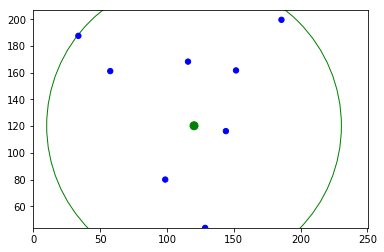

now: 0, sim end time: 100
CHECK node 6 (sf:7 bw:500 freq:8.600000e+08) others: 1
>> node 2 (sf:7 bw:500 freq:8.600000e+08)
frequency coll 500
collision sf node 6 and node 2
collision timing node 6 (0.0,0.768,14.144) node 2 (-0.0102562064934,14.1337437935)
not late enough
pwr: node 6 -117.29 dBm node 2 -118.86 dBm; diff 1.57 dBm
collision pwr both node 6 and node 2
CHECK node 0 (sf:9 bw:125 freq:8.600000e+08) others: 2
>> node 2 (sf:7 bw:500 freq:8.600000e+08)
frequency coll 125
no sf collision
>> node 6 (sf:7 bw:500 freq:8.600000e+08)
frequency coll 125
no sf collision
CHECK node 9 (sf:11 bw:125 freq:8.600000e+08) others: 3
>> node 2 (sf:7 bw:500 freq:8.600000e+08)
frequency coll 125
no sf collision
>> node 6 (sf:7 bw:500 freq:8.600000e+08)
frequency coll 125
no sf collision
>> node 0 (sf:9 bw:125 freq:8.600000e+08)
frequency coll 125
no sf collision
CHECK node 4 (sf:9 bw:500 freq:8.600000e+08) others: 4
>> node 2 (sf:7 bw:500 freq:8.600000e+08)
frequency coll 500
no sf collision
>> no

In [32]:
def get_arguments(argv):
    if len(sys.argv) >= 5:
        nrNodes = int(sys.argv[1])
        avgSendTime = int(sys.argv[2])
        experiment = int(sys.argv[3])
        simtime = int(sys.argv[4])
        if len(sys.argv) > 5:
            full_collision = bool(int(sys.argv[5]))
        else:
            full_collision = False
            
        print "Nodes:", nrNodes
        print "AvgSendTime (exp. distributed):",avgSendTime
        print "Experiment: ", experiment
        print "Simtime: ", simtime
        print "Full Collision: ", full_collision
        return nrNodes, avgSendTime, experiment, simtime, full_collision
    else:
        print "usage: ./loraDir nrNodes avgSendTime experimentNr simtime [full_collision]"
        print "experiment 0 and 1 use 1 frequency only"
        exit(-1)

def getNodePlacement(bsx, bsy, nodes, maxDist):
    # this is very complex prodecure for placing nodes
        # and ensure minimum distance between each pair of nodes
        found = False
        rounds = 0
        
#         global nodes
#         global maxDist
#         global bsx
#         global bsy
        
        while (not found and rounds < 100):
            a = random.random()
            b = random.random()
            if b<a:
                a,b = b,a
                
            posx = b*maxDist*math.cos(2*math.pi*a/b)+bsx
            posy = b*maxDist*math.sin(2*math.pi*a/b)+bsy
            if len(nodes) > 0:
                for index, n in enumerate(nodes):
                    dist = np.sqrt(((abs(n.x-posx))**2)+((abs(n.y-posy))**2))
                    if dist >= 10:
                        x = posx
                        y = posy
                        found = True
                    else:
                        rounds = rounds + 1
                        if rounds >= 100:
                            raise ValueError("could not place new node, giving up")
            else:
#                 print "first node"
                x = posx
                y = posy
                found = True
        
        return x,y
        
if __name__ == "__main__":

    # get arguments from command line
#     nrNodes, avgSendTime, experiment, simtime, full_collision = get_arguments(sys.argv)

    # hard-coded arguments for testing - Adwait
    nrNodes = 10
    avgSendTime = 0.2      # sec
    experiment = 3
    simtime = 100          # sec
    full_collision = True
    
    global nodes
    global packetsAtBS
    global env

    # maximum number of packets the BS can receive at the same time
    global maxBSReceives


    # max distance: 300m in city, 3000 m outside (5 km Utz experiment)
    # also more unit-disc like according to Utz
    global bsId
    
    # These variable keep track of metrics
    global nrCollisions
    global nrReceived
    global nrProcessed
    global nrLost

    global Ptx
    global gamma
    global d0
    global var
    global Lpld0
    global GL

    # create simpy environment for simulations
    env = simpy.Environment()
    
    sensi = np.array([sf7,sf8,sf9,sf10,sf11,sf12])
    
    # set base-station sensitivity based on spreading factor
    if experiment in [0,1,4]:
        minsensi = sensi[5,2]  # 5th row is SF12, 2nd column is BW125
    elif experiment == 2:
        minsensi = -112.0   # no experiments, so value from datasheet
    elif experiment == 3:
        minsensi = np.amin(sensi) ## Experiment 3 can use any setting, so take minimum
    Lpl = Ptx - minsensi
    print "amin", minsensi, "Lpl", Lpl
    maxDist = d0*(math.e**((Lpl-Lpld0)/(10.0*gamma)))
    print "maxDist:", maxDist

    # base station placement
    # This placement ensures the base-station is in the center of the plot - Adwait
    bsx = maxDist+10
    bsy = maxDist+10
    xmax = bsx + maxDist + 20
    ymax = bsy + maxDist + 20

    # prepare graphics and add sink
    if (graphics == 1):
        plt.ion()
        plt.figure()
        ax = plt.gcf().gca()
        # XXX should be base station position
        ax.add_artist(plt.Circle((bsx, bsy), 3, fill=True, color='green'))
        ax.add_artist(plt.Circle((bsx, bsy), maxDist, fill=False, color='green'))

    for i in range(0,nrNodes):
        # myNode takes period (in ms), base station id packetlen (in Bytes)
        # 1000000 = 16 min
        
        # TODO: add node position, SF, CR, BW to class initializer
        try:
            x,y = getNodePlacement(bsx, bsy, nodes, maxDist)
        except Exception:
            raise ValueError("unable to place nodes properly")
            
        node = myNode(i, x, y, bsId, avgSendTime,20)
        nodes.append(node)
        env.process(transmit(env,node))

    #prepare show
    if (graphics == 1):
        plt.xlim([0, max(xmax, ymax)])
        plt.ylim([0, max(xmax, ymax)])
        plt.axes().set_aspect('equal', 'datalim')
        plt.draw()
        plt.show()

    # start simulation
    print "now: {}, sim end time: {}".format(env.now, simtime)
    env.run(until=simtime)

    # print stats and save into file
    print "nrCollisions ", nrCollisions

    # compute energy
    # Transmit consumption in mA from -2 to +17 dBm
    TX = [22, 22, 22, 23,                                      # RFO/PA0: -2..1
          24, 24, 24, 25, 25, 25, 25, 26, 31, 32, 34, 35, 44,  # PA_BOOST/PA1: 2..14
          82, 85, 90,                                          # PA_BOOST/PA1: 15..17
          105, 115, 125]                                       # PA_BOOST/PA1+PA2: 18..20
    # mA = 90    # current draw for TX = 17 dBm
    V = 3.0     # voltage XXX
    sent = sum(n.sent for n in nodes)
    energy = sum(node.packet.rectime * TX[int(node.packet.txpow)+2] * V * node.sent for node in nodes) / 1e6

    print "energy (in J): ", energy
    print "sent packets: ", sent
    print "collisions: ", nrCollisions
    print "received packets: ", nrReceived
    print "processed packets: ", nrProcessed
    print "lost packets: ", nrLost

    # data extraction rate
    der = (sent-nrCollisions)/float(sent)
    print "DER:", der
    der = (nrReceived)/float(sent)
    print "DER method 2:", der

    # this can be done to keep graphics visible
    if (graphics == 1):
        sys.stdin.read()

    # save experiment data into a dat file that can be read by e.g. gnuplot
    # name of file would be:  exp0.dat for experiment 0
    fname = "exp" + str(experiment) + ".dat"
    print fname
    if os.path.isfile(fname):
        res = "\n" + str(nrNodes) + " " + str(nrCollisions) + " "  + str(sent) + " " + str(energy)
    else:
        res = "#nrNodes nrCollisions nrTransmissions OverallEnergy\n" + str(nrNodes) + " " + str(nrCollisions) + " "  + str(sent) + " " + str(energy)
    with open(fname, "a") as myfile:
        myfile.write(res)
    myfile.close()

    # with open('nodes.txt','w') as nfile:
    #     for n in nodes:
    #         nfile.write("{} {} {}\n".format(n.x, n.y, n.nodeid))
    
    # with open('basestation.txt', 'w') as bfile:
    #     bfile.write("{} {} {}\n".format(bsx, bsy, 0))
    